# • DOMAIN: Social media analytics

# • CONTEXT: 
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

# • DATA DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets: Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements.<br>
Content: Each record consists of three attributes:<br>
is_sarcastic: 1 if the record is sarcastic otherwise 0<br>
headline: the headline of the news article<br>
article_link: link to the original news article. Useful in collecting supplementary data<br>
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

# PROJECT OBJECTIVE: 
Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.

# Steps and tasks: [ Total Score: 30 points]
1. Read and explore the data
2. Retain relevant columns
3. Get length of each sentence
4. Define parameters
5. Get indices for words
6. Create features and labels
7. Get vocabulary size
8. Create a weight matrix using GloVe embeddings
9. Define and compile a Bidirectional LSTM model.<br>Hint: Be analytical and experimental here in trying new approaches to design the best model.
10. Fit the model and check the validation accuracy

# 1. Read and explore the data

In [1]:
import pandas as pd

df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


### There are 28619 rows in the dataset. <br><br>Most of the headlines are lower cased.

In [3]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

### There are no null values in the dataset.

In [4]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

<AxesSubplot:>

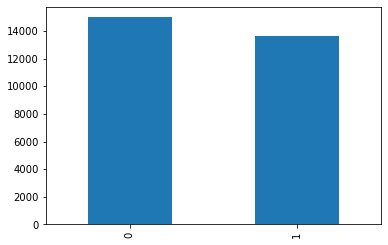

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df['is_sarcastic'].value_counts().plot(kind = 'bar')

### We can see that the dataset is balanced.

# 2. Retain relevant columns

In [6]:
# dropping article_link column as it is not needed

df.drop('article_link', axis=1, inplace=True)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


# 3. Get length of each sentence

In [7]:
df['len'] = df['headline'].astype('str').apply(lambda x: len(x.split(' ')))
df.sort_values(by=['len'], ascending=False).head(10)

,is_sarcastic,headline,len
7302,1,hot wheels ranked number one toy for rolling d...,151
24815,1,"elmore leonard, modern prose master, noted for...",39
23598,0,occasionally you realize someone you thought w...,38
21199,0,"something to vote for on november 8, 2016: ...",34
16588,1,"'12 years a slave,' 'captain phillips,' 'ameri...",31
27972,1,mia farrow: 'it's possible my son was fathered...,30
2146,1,"maya angelou, poet, author, civil rights activ...",29
28081,0,top 3 reasons why 400 ppm co2 is/is not the en...,29
26597,1,jared kushner claims that russian interference...,28
20776,0,"'how do we treat the little people, joan?' i a...",28


In [8]:
df.iloc[7302]['headline']

'hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis ball across room, inching tire down slope until it hits power switch, activating table fan that blows toy ship with nail attached to it across kiddie pool, popping water balloon that fills cup, weighing down lever that forces basketball down track, nudging broomstick on axis to rotate, allowing golf ball to roll into sideways coffee mug, which tumbles down row of hardcover books until handle catches hook attached to lever that causes wooden mallet to slam down on serving spoon, catapulting small ball into cup attached by ribbon to lazy susan, which spins until it pushes d battery down incline plane, tipping over salt shaker to season omelet'

In [9]:
# converting headlines to lower case

df['headline'] = df['headline'].astype('str').apply(lambda x: x.lower())

In [10]:
# removing punctuations from headlines

df['headline'] = df['headline'].replace('[^\w\s]','',regex=True)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Omkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords

In [13]:
stop = set(stopwords.words('english'))

In [14]:
# removing stop words using nltk

df['headline'] = df['headline'].apply(lambda words: ' '.join (word for word in words.split() if word not in stop))

# 4. Define parameters

In [15]:
# taking 39 as max length as line 7302 with length of 151 has garbage value

max_features = 10000
maxlen = 39
embedding_size = 50

# 5. Get indices for words

In [16]:
# applying keras tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['headline'])

# 6. Create features and labels

In [17]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(df['is_sarcastic'])

print('Number of features :',len(X))
print('Types of labels :', np.unique(y))

Number of features : 28619
Types of labels : [0 1]


# 7. Get vocabulary size

In [18]:
print('Vocabulary Size: ', len(tokenizer.word_index) + 1)

Vocabulary Size:  29506


# 8. Create a weight matrix using GloVe embeddings

In [19]:
# reading glove embeddings from the provided file

embedding_file = 'glove.6B.50d.txt'
embedding = {}

for o in open(embedding_file, encoding='utf-8'):
    word = o.split(' ')[0]
    embd = np.asarray(o.split(' ')[1:] , dtype = 'float32')
    embedding[word] = embd

In [20]:
# creating a weight matrix

num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 50))

for word,i in tokenizer.word_index.items():
    if word in embedding.keys():
        embedding_matrix[i] = embedding[word]

len(embedding_matrix)

29506

# 9. Define and compile a Bidirectional LSTM model.
### Hint: Be analytical and experimental here in trying new approaches to design the best model.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten

# embedding layer with input_dim, embedding_size, weights, input_length 
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length = maxlen))

# LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences = True)))

# extract features
model.add(Flatten())

# dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 50)            1475300   
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 256)           183296    
_________________________________________________________________
flatten (Flatten)            (None, 9984)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1278080   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# 10. Fit the model and check the validation accuracy

In [24]:
history = model.fit(X, y, validation_split=0.2, batch_size = 100, epochs = 20)

Epoch 1/20
229/229 [==============================] - 28s 109ms/step - loss: 0.5469 - accuracy: 0.7188 - val_loss: 0.4719 - val_accuracy: 0.7739
Epoch 2/20
229/229 [==============================] - 26s 114ms/step - loss: 0.4109 - accuracy: 0.8104 - val_loss: 0.4069 - val_accuracy: 0.8124
Epoch 3/20
229/229 [==============================] - 25s 110ms/step - loss: 0.3091 - accuracy: 0.8642 - val_loss: 0.4031 - val_accuracy: 0.8199
Epoch 4/20
229/229 [==============================] - 24s 106ms/step - loss: 0.2298 - accuracy: 0.9043 - val_loss: 0.4214 - val_accuracy: 0.8312
Epoch 5/20
229/229 [==============================] - 24s 106ms/step - loss: 0.1720 - accuracy: 0.9298 - val_loss: 0.4718 - val_accuracy: 0.8188
Epoch 6/20
229/229 [==============================] - 26s 115ms/step - loss: 0.1285 - accuracy: 0.9479 - val_loss: 0.5928 - val_accuracy: 0.8202
Epoch 7/20
229/229 [==============================] - 28s 124ms/step - loss: 0.0942 - accuracy: 0.9636 - val_loss: 0.7479 - val_ac

### The validation accuracy is coming around 80%

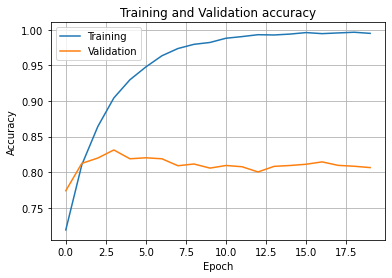

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='best')
plt.grid(True)